pred 파일을 기준으로 평가용 df 만들기

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred = pd.read_csv("../data_csv/XGB테스트.csv", parse_dates=["timestamp"])
pred = pred.set_index("timestamp").sort_index()

# 평가용 데이터: pred 기준으로만 씀 (index 완전 일치)
df_eval = pred.rename(columns={"pred_xgb": "pred"}).copy()

df_eval.head(), df_eval.shape

(                     actual       pred
 timestamp                             
 2013-12-18 05:00:00   5.545   6.632373
 2013-12-18 06:00:00  12.552   7.825272
 2013-12-18 07:00:00  13.082  12.941123
 2013-12-18 08:00:00  19.054  11.586874
 2013-12-18 09:00:00   7.159  12.513745,
 (1747, 2))

공통 지표 함수

In [14]:
def evaluate_metrics(load_series, threshold, ramp_threshold_fixed=None):
    ramp = load_series.diff().abs()

    if ramp_threshold_fixed is None:
        ramp_thr = ramp.quantile(0.95)
    else:
        ramp_thr = ramp_threshold_fixed

    return {
        "peak_exceed": (load_series > threshold).sum(),
        "avg_ramp": ramp.mean(),
        "risky_ramp": (ramp > ramp_thr).sum(),
        "ramp_threshold": ramp_thr
    }

Baseline에서 ramp 기준 고정

In [15]:
threshold = df_eval["actual"].quantile(0.95)

baseline_load = df_eval["actual"].copy()  # baseline은 그냥 actual (또는 너 baseline 방식 넣어도 됨)
base_metrics = evaluate_metrics(baseline_load, threshold)

ramp_threshold_fixed = base_metrics["ramp_threshold"]

base_metrics

{'peak_exceed': np.int64(88),
 'avg_ramp': np.float64(4.341395189003437),
 'risky_ramp': np.int64(88),
 'ramp_threshold': np.float64(10.5135)}

ESS 파라미터 sweep 정의

In [16]:
ESS_POWER_RANGE = [2, 4, 6, 8]   # kW
ESS_ENERGY_RANGE = [5, 10, 20]   # kWh
SOC_INIT = 0.5
ALPHA = 0.10

ESS 시뮬레이션

In [17]:
def simulate_ess(df_eval, power_max, energy_max, alpha=0.10):
    soc = SOC_INIT * energy_max
    load_adj = df_eval["actual"].copy()

    for ts in df_eval.index:
        actual = df_eval.loc[ts, "actual"]
        pred = df_eval.loc[ts, "pred"]

        if (pred > threshold) and (soc > 0):
            discharge = min(power_max, alpha * actual, soc)
            load_adj.loc[ts] = actual - discharge
            soc -= discharge

    return load_adj

Sweep 실행

In [18]:
results = []

for p in ESS_POWER_RANGE:
    for e in ESS_ENERGY_RANGE:
        load_ess = simulate_ess(df_eval, power_max=p, energy_max=e, alpha=ALPHA)

        metrics = evaluate_metrics(load_ess, threshold, ramp_threshold_fixed=ramp_threshold_fixed)
        metrics.update({"power_max": p, "energy_max": e})
        results.append(metrics)

result_df = pd.DataFrame(results).drop(columns=["ramp_threshold"])
result_df

,peak_exceed,avg_ramp,risky_ramp,power_max,energy_max
0,87,4.339407,88,2,5
1,87,4.340280,88,2,10
2,87,4.340702,89,2,20
3,87,4.339407,88,4,5
4,87,4.340280,88,4,10
5,87,4.340702,89,4,20
6,87,4.339407,88,6,5
7,87,4.340280,88,6,10
8,87,4.340702,89,6,20
9,87,4.339407,88,8,5


Trade-off 그림 -1

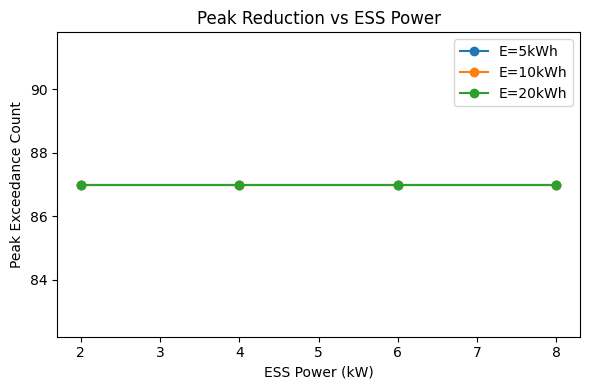

In [19]:
plt.figure(figsize=(6,4))
for e in ESS_ENERGY_RANGE:
    subset = result_df[result_df["energy_max"] == e]
    plt.plot(subset["power_max"], subset["peak_exceed"], marker="o", label=f"E={e}kWh")

plt.xlabel("ESS Power (kW)")
plt.ylabel("Peak Exceedance Count")
plt.title("Peak Reduction vs ESS Power")
plt.legend()
plt.tight_layout()
plt.show()

Trade-off 그림 -2

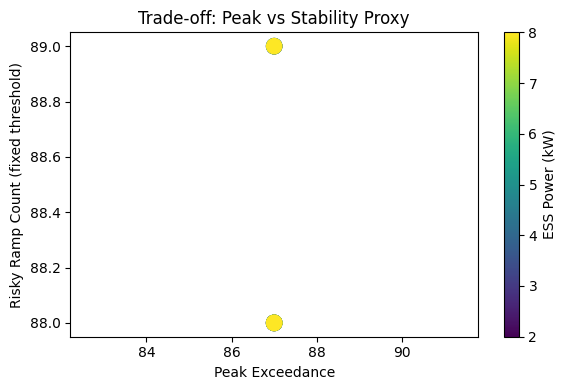

In [20]:
plt.figure(figsize=(6,4))
plt.scatter(
    result_df["peak_exceed"],
    result_df["risky_ramp"],
    c=result_df["power_max"],
    s=120
)

plt.xlabel("Peak Exceedance")
plt.ylabel("Risky Ramp Count (fixed threshold)")
plt.colorbar(label="ESS Power (kW)")
plt.title("Trade-off: Peak vs Stability Proxy")
plt.tight_layout()
plt.show()